# Strategia dla spółki Microsoft
### Case 3

Strategia inwestycyjna (decyzje wejścia i wyjścia) dla spółki  Microsoft (MSFT), 

test w okresie od 01.01.2024 - 06.05.2024



Stwórz model generujący sygnały kupna i sprzedaży na rynku

Decyzje ma generować jeden z algorytmów uczenia maszynowego, po optymalizacji hiperparametrów

Zrób backtest wybranego modelu, użyj biblioteki przystosowanej do backtestów

Pamiętaj o wnioskach i wizualizacji wyników

4 pkt z oceny będą zależne od wyników inwestycji

Inwestujesz w wylosowaną spółkę przez określony okres, ale można wykorzystać także inne dane niż historyczne (np. obliczone wskaźniki)


### Główny zamysł strategii

**Sprawdzenie zależności pomiędzy spółką a indeksem, w którym się znajduje**

Z przeprowadzonej analizy wyszło, że istnieje dość wysoka korelacja pomiędzy szeregami (korelacja zwrotów logarytmicznych = 0.88). Korelacja opóźnionych zwrotów indeksu NASDAQ jest ujemna i wynosi -0.20. Ta niewielka zależność sugeruje, że jeśli indeks NASDAQ spada, możemy spodziewać się niewielkiego wzrostu MSFT.

**Przyczynowość w sensie Grangera** 

Wyniki testu pokazały, że przeszłe wartości NASDAQ są przydatne do przewidywania przyszłych wartości MSFT.

**Model**

Wykorzystany został model LSTM, ponieważ jest on często wykorzystywany w szeregach czasowych

**Strategia**

Strategia opiera się na sygnałach kupna i sprzedaży, które zostały wygeneowane na podstawie predykcji dla indeksu NASDAQ. Sygnały generowane są wedłg następującej logiki:

    Jeśli przewidywana cena na jutro jest wyższa niż dzisiejsza - kup
    Jeśli niższa - sprzedaj
    W przeciwnym wypadku - trzymaj
    
Ta strategia wygenerowała zwrot na poziomie 22%.
    
Dla identycznych sygnałów generowanych na podstawie MSFT strategia uzyskała zwrot = 13%.
    
    
 **Próby**

- predykcje MSFT, sygnały na ich podstawie - zwrot ok. 15-17%
- predykcje MSFT, sygnały, MACD, BB - zwrot ok. -3 - 8%
- predykcje MSFT, sygnały, MACD - zwrot ok.  8%
- predykcje MSFT, ich średnia z 3 dni porównana z predykcjami MSFT - słabe wyniki

Sygnały miały kilka wersji, w zależności od ustawionej konfiguracji (porównanie ceny z dzisiaj z predykcją na x dzień).


### Biblioteki

In [1]:
import ffn # http://pmorissette.github.io/ffn/index.html

import yfinance as yf
import datetime as dt

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox

from ta.trend import MACD
import ta

from backtesting.lib import SignalStrategy, TrailingStrategy
from backtesting import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from scipy.stats import randint as sp_randint
from scipy.stats import uniform

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

from kerastuner import RandomSearch


Loading BokehJS ...

#### Pobranie szeregu czasowego

In [2]:
start_date = dt.datetime(2019,1,1) # (RRR-MM-DD)
end_date = dt.datetime(2024,5,6)

ticker = 'MSFT'

#loading from yahoo finance
data = yf.download(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


#### Ogólny pregląd danych 

In [3]:
data.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,1344.00,1344.00,1344.00,1344.00,1344.00,1344.00
mean,247.10,249.58,244.53,247.17,242.12,28966463.84
std,81.66,82.23,80.96,81.62,82.83,12202819.08
min,99.55,100.19,97.20,97.40,92.15,8989200.00
25%,182.82,184.41,181.10,182.90,176.33,21330750.00
50%,247.80,250.96,245.81,248.38,244.38,25991200.00
75%,304.31,308.28,301.49,304.44,298.02,33068725.00
max,429.83,430.82,427.16,429.37,428.60,97012700.00


Widać, że spółka wypłaca dywidendę, więc będę używać *"Adj Close"*.

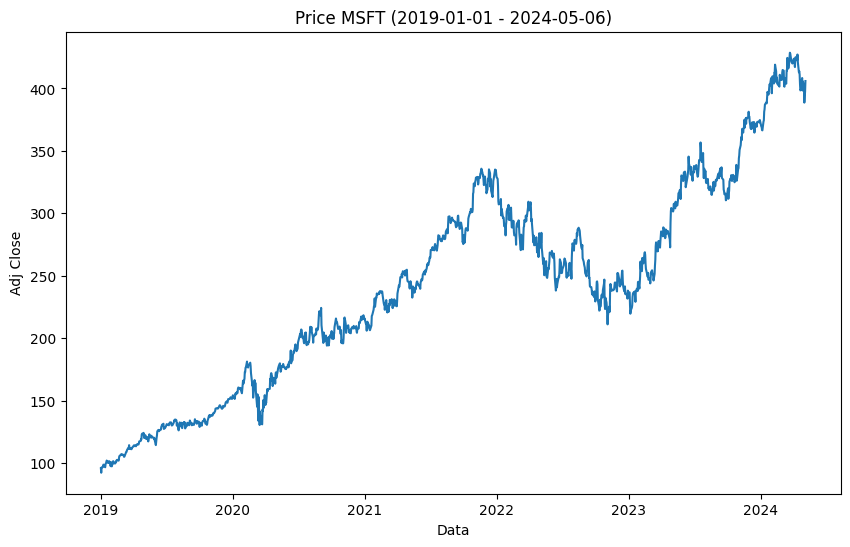

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data['Adj Close'])
plt.xlabel('Data')
plt.ylabel('Adj Close')
plt.title(f'Price {ticker} ({start_date.strftime("%Y-%m-%d")} - {end_date.strftime("%Y-%m-%d")})')
plt.show()

### Dane treningowe

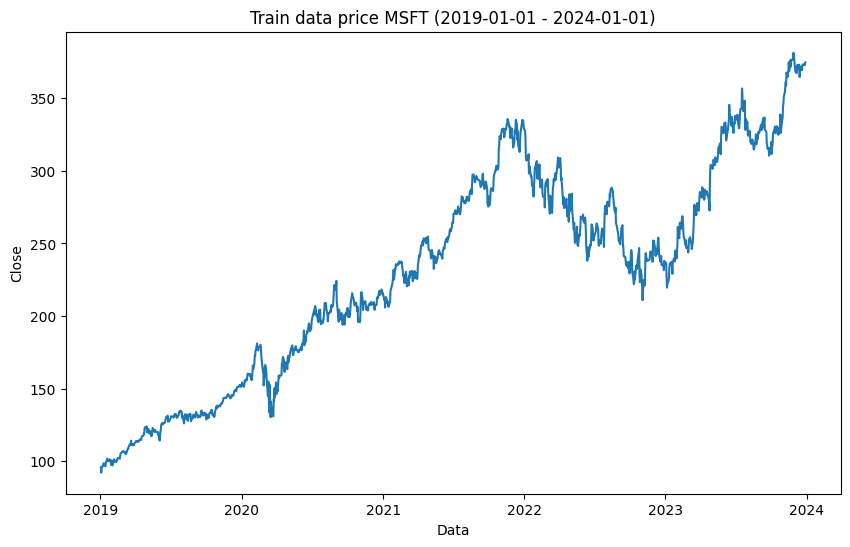

In [5]:
train_start = dt.datetime(2019,1,1)
train_end = dt.datetime(2024,1,1)

train_data = data.loc[(data.index >= train_start) & (data.index <= train_end)]
plt.figure(figsize=(10, 6))
plt.plot(train_data['Adj Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.title(f'Train data price {ticker} ({train_start.strftime("%Y-%m-%d")} - {train_end.strftime("%Y-%m-%d")})')
plt.show()

### Dane testowe

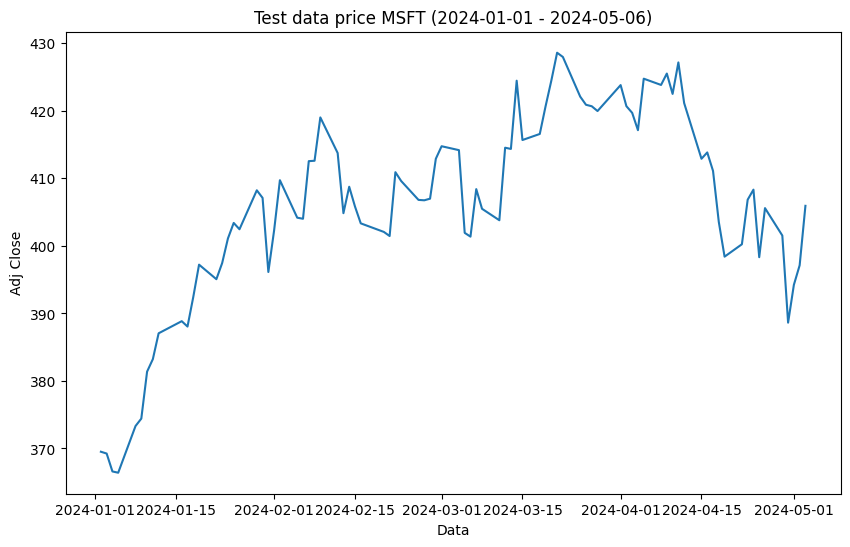

In [6]:
test_start = dt.datetime(2024,1,1) # (RRR-MM-DD)
test_end = dt.datetime(2024,5,6)

test_data = data.loc[(data.index >= test_start) & (data.index <= test_end)]
plt.figure(figsize=(10, 6))
plt.plot(test_data['Adj Close'])
plt.xlabel('Data')
plt.ylabel('Adj Close')
plt.title(f'Test data price {ticker} ({test_start.strftime("%Y-%m-%d")} - {test_end.strftime("%Y-%m-%d")})')

plt.show()

### Zwroty
Używam zwrotów logarytmicznych, ponieważ są bardziej odporne na wahania i wartości odstające. Wykorzystuję bibliotekę [ffn](http://pmorissette.github.io/ffn/index.html).

In [7]:
data['returns'] = data['Adj Close'].to_log_returns()
data = data.dropna()

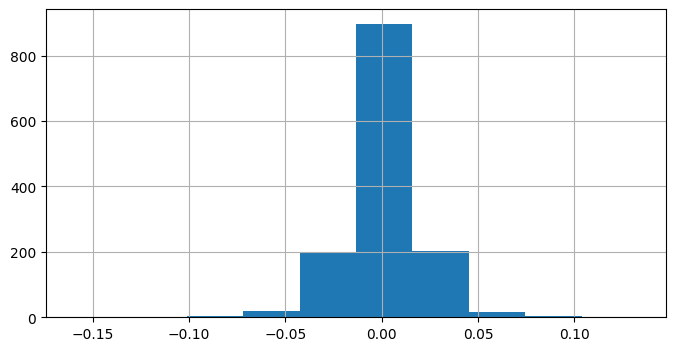

In [8]:
ax = data['returns'].hist(figsize=(8, 4))

#### Porównanie z indeksem NASDAQ (^IXIC)

In [9]:
# downloading closing prices during the training period to check the relationship between the indices
df = ffn.get('^IXIC:Adj Close, MSFT:Adj Close', start=train_start, end=train_end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
# calculate log returns 
returns = df.to_log_returns().dropna()
print(returns.head())

             ixicadj   msftadj
Date                          
2019-01-03 -0.030840 -0.037482
2019-01-04  0.041720  0.045460
2019-01-07  0.012477  0.001275
2019-01-08  0.010718  0.007224
2019-01-09  0.008673  0.014198


In [11]:
df.head()

,ixicadj,msftadj
Date,,
2019-01-02,6665.939941,95.673454
2019-01-03,6463.500000,92.153831
2019-01-04,6738.859863,96.439819
2019-01-07,6823.470215,96.562843
2019-01-08,6897.000000,97.262970


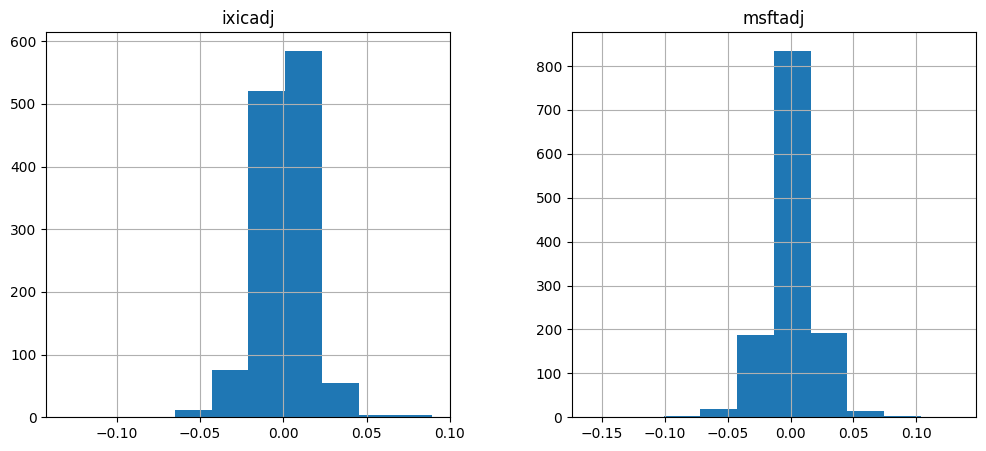

In [12]:
# comparision of returns between indices
ax2 = returns.hist(figsize=(12, 5))

In [13]:
# correlation
returns.corr().as_format('.2f')

,ixicadj,msftadj
ixicadj,1.00,0.88
msftadj,0.88,1.00


Oba szeregi są ze sobą wysoko skorelowane. 

In [15]:
# statystyki szeregów
perf = df.calc_stats()
perf.display()

Stat                 ixicadj     msftadj
-------------------  ----------  ----------
Start                2019-01-02  2019-01-02
End                  2023-12-29  2023-12-29
Risk-free rate       0.00%       0.00%

Total Return         125.19%     291.61%
Daily Sharpe         0.77        1.05
Daily Sortino        1.22        1.76
CAGR                 17.67%      31.48%
Max Drawdown         -36.40%     -37.15%
Calmar Ratio         0.49        0.85

MTD                  5.52%       -0.76%
3m                   13.56%      19.34%
6m                   10.45%      12.70%
YTD                  43.42%      58.19%
1Y                   43.26%      57.41%
3Y (ann.)            5.32%       19.89%
5Y (ann.)            17.67%      31.48%
10Y (ann.)           -           -
Since Incep. (ann.)  17.67%      31.48%

Daily Sharpe         0.77        1.05
Daily Sortino        1.22        1.76
Daily Mean (ann.)    19.46%      32.03%
Daily Vol (ann.)     25.16%      30.49%
Daily Skew           -0.44       -0.00

W długoterminowej perspektywie oba szeregi majac

In [16]:
# monthly returns
perf['ixicadj'].display_monthly_returns()

  Year    Jan    Feb     Mar     Apr    May    Jun    Jul    Aug     Sep    Oct    Nov    Dec     YTD
------  -----  -----  ------  ------  -----  -----  -----  -----  ------  -----  -----  -----  ------
  2019   9.24   3.44    2.61    4.74  -7.93   7.42   2.11  -2.6     0.46   3.66   4.5    3.54   34.6
  2020   1.99  -6.38  -10.12   15.45   6.75   5.99   6.82   9.59   -5.16  -2.29  11.8    5.65   43.64
  2021   1.42   0.93    0.41    5.4   -1.53   5.49   1.16   4      -5.31   7.27   0.25   0.69   21.39
  2022  -8.98  -3.43    3.41  -13.26  -2.05  -8.71  12.35  -4.64  -10.5    3.9    4.37  -8.73  -33.1
  2023  10.68  -1.11    6.69    0.04   5.8    6.59   4.05  -2.17   -5.81  -2.78  10.7    5.52   43.42


In [17]:
# monthly returns
perf['msftadj'].display_monthly_returns()

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug     Sep    Oct    Nov    Dec     YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  ------  -----  -----  -----  ------
  2019   3.27   7.74   5.28  10.73  -4.95   8.31   1.72   1.5     0.85   3.12   5.95   4.17   58.26
  2020   7.95  -4.57  -2.65  13.63   2.54  11.06   0.74  10.28   -6.74  -3.74   6.01   3.9    42.53
  2021   4.29   0.41   1.46   6.96  -0.76   8.5    5.17   6.16   -6.61  17.63  -0.13   1.73   52.48
  2022  -7.53  -3.72   3.19  -9.99  -1.81  -5.53   9.31  -6.67  -10.93  -0.33  10.22  -6     -28.02
  2023   3.33   0.9   15.59   6.58   7.11   3.7   -1.36  -2.22   -3.66   7.08  12.29  -0.76   58.19


Można zauważyć, że *MSFT* wrócił do poziomu sprzed pandemii. Z wysoko ujemnego zwrotu w 2022 odbiła do $58\%$ (YTD). 

#### Sprawdzenie korelacji pomiędzy opóźnionymi szeregami

In [42]:
returns['lag_msft'] = returns['msftadj'].shift(1)
returns

,ixicadj,msftadj,lag_msft
Date,,,
2019-01-03,-0.030840,-0.037482,NaN
2019-01-04,0.041720,0.045460,-0.037482
2019-01-07,0.012477,0.001275,0.045460
2019-01-08,0.010718,0.007224,0.001275
2019-01-09,0.008673,0.014198,0.007224
...,...,...,...
2023-12-22,0.001943,0.002780,0.007848
2023-12-26,0.005428,0.000214,0.002780
2023-12-27,0.001631,-0.001576,0.000214


In [44]:
returns['lag_ixic'] = returns['ixicadj'].shift(1)
returns

,ixicadj,msftadj,lag_msft,lag_ixic
Date,,,,
2019-01-03,-0.030840,-0.037482,NaN,NaN
2019-01-04,0.041720,0.045460,-0.037482,-0.030840
2019-01-07,0.012477,0.001275,0.045460,0.041720
2019-01-08,0.010718,0.007224,0.001275,0.012477
2019-01-09,0.008673,0.014198,0.007224,0.010718
...,...,...,...,...
2023-12-22,0.001943,0.002780,0.007848,0.012503
2023-12-26,0.005428,0.000214,0.002780,0.001943
2023-12-27,0.001631,-0.001576,0.000214,0.005428


In [46]:
lag_msft_corr = returns[['ixicadj', 'lag_msft']]
lag_msft_corr=lag_msft_corr.dropna()
lag_msft_corr.corr().as_format('.2f')

,ixicadj,lag_msft
ixicadj,1.00,-0.15
lag_msft,-0.15,1.00


In [47]:
lag_ixi_corr = returns[['msftadj', 'lag_ixic']]
lag_ixi_corr.dropna()
lag_ixi_corr.corr().as_format('.2f')

,msftadj,lag_ixic
msftadj,1.00,-0.20
lag_ixic,-0.20,1.00


Istnienje niewielka zależność. Jeśli indeks *NASDAQ* spada, możemy spodziewać się niewielkiego wzrostu *MSFT*.

### Sprawdzanie przyczynowości w sensie Grangera

In [48]:
my_data = pd.DataFrame({'NASDAQ': returns['ixicadj'], 'MSFT': returns['msftadj']})

# Wybór modelu VAR
model = VAR(my_data)
results = model.fit(maxlags=1, ic='aic')

print(results.summary())

# Test Ljung-Boxa
ljung_box_gold = acorr_ljungbox(results.resid['NASDAQ'])
print(f"Ljung-Box test for NASDAQ: {ljung_box_gold}")

ljung_box_silver = acorr_ljungbox(results.resid['MSFT'])
print(f"Ljung-Box test for MSFT: {ljung_box_silver}")

# Test stabilności
stability_test = results.test_causality('NASDAQ', 'MSFT', kind='f')
print(stability_test.summary())

stability_test_2 = results.test_causality('MSFT', 'NASDAQ', kind='f')
print(stability_test_2.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 08, Jun, 2024
Time:                     13:54:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -17.6583
Nobs:                     1256.00    HQIC:                  -17.6736
Log likelihood:           7546.45    FPE:                2.09143e-08
AIC:                     -17.6828    Det(Omega_mle):     2.08147e-08
--------------------------------------------------------------------
Results for equation NASDAQ
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000793         0.000444            1.788           0.074
L1.NASDAQ        -0.107928         0.057805           -1.867           0.062
L1.MSFT          -0.047913         0.047848           -1.001           0.31

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


**MSFT**

$L1.NASDAQ \|\ -0.161305 \   |  \ 0.069309    \ | \  -2.327 \  |  \  0.020$

Lag NASDAQ ma ujemny i istotny wpływ na MSFT w następnym okresie (p-value = 0.020).

Brak autokorelacji reszt dla większości opóźnień.

**Test przyczynowości Grangera:**
- MSFT nie wypływa na NASDAQ (p-value = 0.317)
- NASDAQ wpływa na MSFT (p-value  =0.020)

Przeszłe wartości NASDAQ są przydatne do przewidywania przyszłych wartości MSFT. 

## Przygotowanie danych MSFT pod deep learning

In [79]:
# # Przygotowanie danych
# prices_train = train_data["Adj Close"].values.reshape(-1, 1)  # konwersja do numpy
# prices_test = test_data["Adj Close"].values.reshape(-1, 1)
# #
# # Przeskalowanie do zakresu [0, 1]
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_prices_train = scaler.fit_transform(prices_train)
# scaled_prices_test = scaler.transform(prices_test)

# # Tworzenie sekwencji danych dla LSTM
# def create_sequences(data, sequence_length):
#     X, y = [], []
#     for i in range(len(data) - sequence_length):
#         X.append(data[i:i+sequence_length])
#         y.append(data[i+sequence_length])
#     return np.array(X), np.array(y)

# # Określenie długości sekwencji (liczba kroków wstecznych)
# sequence_length = 10

# # Utworzenie sekwencji danych treningowych i testowych
# X_train, y_train = create_sequences(scaled_prices_train, sequence_length)
# X_test, y_test = create_sequences(scaled_prices_test, sequence_length)

# print("Rozmiar danych treningowych:", X_train.shape, y_train.shape)
# print("Rozmiar danych testowych:", X_test.shape, y_test.shape)

Rozmiar danych treningowych: (1248, 10, 1) (1248, 1)
Rozmiar danych testowych: (76, 10, 1) (76, 1)


## LSTM

In [162]:
# # Model LSTM 
# def create_lstm_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(units=50, input_shape=input_shape, return_sequences=True))
#     model.add(LSTM(units=50))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# # Tworzenie
# input_shape = (X_train.shape[1], X_train.shape[2])  # Kształt danych wejściowych dla modelu LSTM
# lstm_model = create_lstm_model(input_shape)

# # Trenowanie
# lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# # Predykcja cen dla danych testowych
# predicted_prices = lstm_model.predict(X_test)


In [80]:
# Hiperparametryzajca
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                   input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32)))
    model.add(Dense(1))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
                  loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # liczba konfiguracji do przetestowania
    executions_per_trial=3,  # liczba prób na konfigurację, aby zniwelować fluktuacje wyników
    directory='output_dir',  # katalog z wynikami
    project_name='LSTM_hyperparam_tuning'  
)

Reloading Tuner from output_dir\LSTM_hyperparam_tuning\tuner0.json


In [81]:
# input_shape = (X_train.shape[1], X_train.shape[2])  # Kształt danych wejściowych dla modelu LSTM

# tuner.search_space_summary()

# tuner.search(X_train, y_train, epochs=5, validation_split=0.2)

# # Pobranie najlepszego modelu
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Predykcja cen dla danych testowych
# predicted_prices = best_model.predict(X_test)


Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step


In [82]:
# mse = mean_squared_error(y_test, predicted_prices)
# print("Mean Squared Error (MSE) na danych testowych:", mse.round(5))

Mean Squared Error (MSE) na danych testowych: 0.00075


In [83]:
# print(best_model_hyperparameters.values)

{'units': 288, 'optimizer': 'adam'}


In [84]:
# predicted_prices_unscaled = scaler.inverse_transform(predicted_prices)

In [85]:
# # Dodanie przewidywanych cen do testowych danych
# test_data['Pred_Close_msft'] = np.nan
# test_data['Pred_Close_msft'].iloc[sequence_length:] = predicted_prices_unscaled.flatten()

## NASDAQ
#### Model LSTM


In [17]:
ticker = '^NDX'

#loading from yahoo finance
nasdaq_train = yf.download(ticker, train_start, train_end)
nasdaq_test = yf.download(ticker, test_start, test_end)

# Przygotowanie danych
nasdaq_train = nasdaq_train["Adj Close"].values.reshape(-1, 1)  # dane NASDAQ dla treningu
nasdaq_test = nasdaq_test["Adj Close"].values.reshape(-1, 1)  # dane NASDAQ dla testu

# Przeskalowanie do zakresu [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices_train = scaler.fit_transform(nasdaq_train)
scaled_prices_test = scaler.transform(nasdaq_test)

# Tworzenie sekwencji danych dla LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Przeskalowanie do zakresu [0, 1]
nq_prices_train = scaler.fit_transform(nasdaq_train)
nq_prices_test = scaler.transform(nasdaq_test)

# Określenie długości sekwencji (liczba kroków wstecznych)
sequence_length = 10

# Utworzenie sekwencji danych treningowych i testowych
X_train_nq, y_train_nq = create_sequences(nq_prices_train, sequence_length)
X_test_nq, y_test_nq = create_sequences(nq_prices_test, sequence_length)

print("Rozmiar danych treningowych:", X_train_nq.shape, y_train_nq.shape)
print("Rozmiar danych testowych:", X_test_nq.shape, y_test_nq.shape)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Rozmiar danych treningowych: (1248, 10, 1) (1248, 1)
Rozmiar danych testowych: (76, 10, 1) (76, 1)


In [19]:
# LSTM dla NASDAQ
input_shape = (X_train_nq.shape[1], X_train_nq.shape[2])  # Kształt danych wejściowych dla modelu LSTM

tuner.search_space_summary()

tuner.search(X_train_nq, y_train_nq, epochs=5, validation_split=0.2)

# Pobranie najlepszego modelu
best_model_n = tuner.get_best_models(num_models=1)[0]
best_model_hyperparameters_n = tuner.get_best_hyperparameters(num_trials=1)[0]

# Predykcja cen dla danych testowych
predicted_prices_n = best_model_n.predict(X_test_nq)


Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step


In [20]:
print(best_model_hyperparameters_n.values)

{'units': 288, 'optimizer': 'adam'}


In [23]:
mse_n = mean_squared_error(y_test_nq, predicted_prices_n)
print("Mean Squared Error (MSE) na danych testowych (NASDAQ):", mse_n.round(5))

predicted_prices_unscaled_n = scaler.inverse_transform(predicted_prices_n)

# Dodanie przewidywanych cen do testowych danych
test_data['Pred_Close_nasdaq'] = np.nan
test_data['Pred_Close_nasdaq'].iloc[sequence_length:] = predicted_prices_unscaled_n.flatten()

Mean Squared Error (MSE) na danych testowych (NASDAQ): 0.00065


In [24]:
test_data

,Open,High,Low,Close,Adj Close,Volume,Pred_Close_nasdaq
Date,,,,,,,
2024-01-02,373.859985,375.899994,366.769989,370.869995,369.518921,25258600,NaN
2024-01-03,369.010010,373.260010,368.510010,370.600006,369.249908,23083500,NaN
2024-01-04,370.670013,373.100006,367.170013,367.940002,366.599579,20901500,NaN
2024-01-05,368.970001,372.059998,366.500000,367.750000,366.410309,20987000,NaN
2024-01-08,369.299988,375.200012,369.010010,374.690002,373.325012,23134000,NaN
...,...,...,...,...,...,...,...
2024-04-29,405.250000,406.320007,399.190002,402.250000,401.525757,19582100,17417.064453
2024-04-30,401.489990,402.160004,389.170013,389.329987,388.628998,28781400,17446.857422
2024-05-01,392.609985,401.720001,390.309998,394.940002,394.228912,23562500,17460.285156


In [88]:
# tworzenie pomocniczego dataframe
strategy_data = test_data.dropna().copy()

In [90]:
strategy_data

,Open,High,Low,Close,Adj Close,Volume,Pred_Close_nasdaq,Pred_Close_msft
Date,,,,,,,,
2024-01-17,387.980011,390.109985,384.809998,389.470001,388.051147,22234100,16687.093750,378.062988
2024-01-18,391.720001,393.989990,390.119995,393.869995,392.435120,23392100,16720.564453,380.307831
2024-01-19,395.760010,398.670013,393.500000,398.670013,397.217682,29272000,16769.849609,382.678040
2024-01-22,400.019989,400.619995,393.589996,396.510010,395.065521,27016900,16848.144531,385.394226
2024-01-23,395.750000,399.380005,393.929993,398.899994,397.446808,20525900,16935.931641,387.891815
...,...,...,...,...,...,...,...,...
2024-04-29,405.250000,406.320007,399.190002,402.250000,401.525757,19582100,17417.064453,403.711060
2024-04-30,401.489990,402.160004,389.170013,389.329987,388.628998,28781400,17446.857422,402.999420
2024-05-01,392.609985,401.720001,390.309998,394.940002,394.228912,23562500,17460.285156,401.326050


In [92]:
strategy_data['Signal'] = 0

for i in range(sequence_length, len(strategy_data) - 1):
    today_close = strategy_data['Pred_Close_nasdaq'].iloc[i]
    tomorrow_predicted_close = strategy_data['Pred_Close_nasdaq'].iloc[i + 1]

    if tomorrow_predicted_close > today_close:
        strategy_data['Signal'].iloc[i + 1] = 1  # Kup
    elif tomorrow_predicted_close < today_close:
        strategy_data['Signal'].iloc[i + 1] = -1  # Sprzedaj
    else:
        strategy_data['Signal'].iloc[i + 1] = 0  # Brak zmiany

In [93]:

# strategy_data['Signal_msft'] = 0

# for i in range(sequence_length, len(strategy_data) - 1):
#     today_close = strategy_data['Pred_Close_msft'].iloc[i]
#     tomorrow_predicted_close = strategy_data['Pred_Close_msft'].iloc[i + 1]

#     if tomorrow_predicted_close > today_close:
#         strategy_data['Signal_msft'].iloc[i + 1] = 1  # Kup
#     elif tomorrow_predicted_close < today_close:
#         strategy_data['Signal_msft'].iloc[i + 1] = -1  # Sprzedaj
#     else:
#         strategy_data['Signal_msft'].iloc[i + 1] = 0  # Brak zmiany

In [94]:
strategy_data.Signal.value_counts()

Signal
 1    41
-1    24
 0    11
Name: count, dtype: int64

In [98]:

# ttp       ssl       size_tr 
# 0.012830  0.089043  0.998807    12233.405128
# 0.012834  0.079905  0.999584    12233.958936
# 0.012842  0.091410  0.999717    12235.267326

class LSTMCustomStrategy(SignalStrategy):
    ssl = 0.091410
    ttp = 0.012842
    size_tr = 0.999717
    
    def init(self):
        super().init()
        self.signal = self.I(lambda x: strategy_data['Signal'], 'Signal')

    def next(self):
        close = self.data['Adj Close']
        signal = self.signal
        
        upper_tp = close * (1 + self.ttp)
        upper_sl = close * (1 + self.ssl)
        lower_sl = close * (1 - self.ssl)
        lower_tp = close * (1 - self.ttp)

        if signal == 1 and not self.position.is_long:  
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 and not self.position.is_short:  
            self.sell(size=self.size_tr, sl=upper_sl, tp=lower_tp)

            
bt = Backtest(strategy_data, LSTMCustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
print(stats)

# Optymalizacja parametrów
# stats_skopt, heatmap, optimize_result = bt.optimize(
#     ttp=[0.01, 0.1],
#     ssl=[0.01, 0.1],
#     size_tr=[0.4, 1], 
#     maximize='Equity Final [$]',
#     method='skopt',
#     max_tries=1000,
#     random_state=10,
#     return_heatmap=True,
#     return_optimization=True
# )
# heatmap.sort_values().iloc[-3:]

Start                     2024-01-17 00:00:00
End                       2024-05-03 00:00:00
Duration                    107 days 00:00:00
Exposure Time [%]                   84.210526
Equity Final [$]                  12235.25909
Equity Peak [$]                   12235.25909
Return [%]                          22.352591
Buy & Hold Return [%]                4.413691
Return (Ann.) [%]                   95.212142
Volatility (Ann.) [%]               33.353108
Sharpe Ratio                         2.854671
Sortino Ratio                       10.656952
Calmar Ratio                        20.984301
Max. Drawdown [%]                   -4.537304
Avg. Drawdown [%]                   -1.280067
Max. Drawdown Duration       34 days 00:00:00
Avg. Drawdown Duration        8 days 00:00:00
# Trades                                   19
Win Rate [%]                        89.473684
Best Trade [%]                       4.409767
Worst Trade [%]                     -0.199601
Avg. Trade [%]                    